# Prepare Triplets for Neo4j Visualization and Use Cases Determination

In [1]:
import pandas as pd
import ast
import spacy
import re
import os
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Load triplets dataframe 
triplets_df_nostop= pd.read_csv(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\triplets_dataframe_clean.csv')

def convert_to_list(column):
    return column.apply(ast.literal_eval)

triplets_df_nostop['Content'] = convert_to_list(triplets_df_nostop['Content'])
triplets_df_nostop['triplets_list'] = convert_to_list(triplets_df_nostop['triplets_list'])

In [3]:
triplets_df_nostop.head()

,Title,Articles,Content,coreference_list_ready,Cleaned_Content_new,triplets_list,empty_list,many_triplets,head,relation,tail,is_stopword
0,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,this regulation lays down the rules for the es...,this regulation lays down the rules for the es...,"[this regulation, lay, the rules for the estab...",False,False,this regulation,lay,the rules for the establishment and the implem...,False
1,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,applicant means a natural person or an entity ...,applicant means a natural person or an entity ...,"[applicant, mean, a natural person or an entit...",False,True,applicant,mean,a natural person or an entity with or without ...,False
2,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,application document means a tender a request ...,application document means a tender a request ...,"[application document, mean, a tender a reques...",False,False,application document,mean,a tender a request to participate a grant appl...,False
3,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,award procedure means a procurement procedure ...,award procedure means a procurement procedure ...,"[award procedure, mean, a procurement procedur...",False,False,award procedure,mean,a procurement procedure a grant award procedur...,False
4,"TITLE I \nSUBJECT MATTER, DEFINITIONS AND GENE...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,basic act means a legal act other than a recom...,basic act means a legal act other than a recom...,"[basic act, mean, a legal act other than a rec...",False,True,basic act,mean,a legal act other than a recommendation or an ...,False


In [4]:
def keep_sec_word(relation):
    if ' ' in relation:
        return relation.split(' ')[1].strip()
    else:
        return relation 
    
triplets_df_nostop['relation'] = triplets_df_nostop['relation'].apply(keep_sec_word)

In [5]:
# Remove stopwords, punctuation from heads 
nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.get_pipe("lemmatizer")


stop_words = spacy.lang.en.stop_words.STOP_WORDS 
stopwords = list(stop_words)
punctuation = '!@#$%^&*_-+={}[];"\'|<>,?/~`’‘()'



def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def tokens(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        tokens.append(token)
    return tokens

def remove_punct(text):
    tokens_list = tokens(text)
    new_list = []
    for token in tokens_list:
        new_token = ""
        for letter in token.text:
            if letter not in punctuation:
                new_token = new_token + letter
        new_list.append(new_token)
    return new_list

def remove_punct_text(text):
    tokens_list = tokens(text)
    new_list = []
    for token in tokens_list:
        new_token = ""
        for letter in token.text:
            if letter not in punctuation:
                new_token = new_token + letter
        new_list.append(new_token)
    return " ".join(new_list)

def remove_stopwords(text):
    text_tokens = remove_punct(text)
    new_text = " "
    for token in text_tokens:
        if token not in stopwords:
               new_text = new_text + ' ' + str(token)
    return lemmatize(new_text).strip()

def remove_stopwords_no_lemma(text):
    text_tokens = remove_punct(text)
    new_text = " "
    for token in text_tokens:
        if token not in stopwords:
               new_text = new_text + ' ' + str(token)
    return new_text.strip()

def tokens_len(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        tokens.append(token)
    return len(tokens)

def clean_noun_chunks(chunk_list):
    clean_chunk_list = []
    for chunk in chunk_list:
        if len(chunk) != 0:
            clean_chunk_list.append(remove_stopwords(chunk))
    return clean_chunk_list

# def get_noun_chuncks(text_head):
#     chunks = []
#     doc = nlp(text_head)
#     for chunk in doc.noun_chunks:
#         chunks.append(chunk.text)
#     if len(chunks) != 0:
#         return chunks
#     else:
#         return [text_head]
    
def get_noun_chuncks(text_head):
    chunks = []
    doc = nlp(text_head)
    for chunk in doc.noun_chunks:
        new_chunk = remove_stopwords_no_lemma(chunk.text)
        chunks.append(new_chunk)
    if len(chunks) != 0:
        return chunks
    else:
        return [text_head]


def tf_idf_dict(corpus_list):
    tfidf = TfidfVectorizer(stop_words='english', smooth_idf=True)
    result = tfidf.fit_transform(corpus_list)

    feature_names = tfidf.get_feature_names_out()
    df_tfidf = pd.DataFrame(result.toarray(), columns=feature_names)

    word_scores = df_tfidf.sum(axis=0)
    sorted_words = word_scores.sort_values(ascending=False)

    sorted_words_asc = word_scores.sort_values(ascending=False)

    sorted_words_asc = sorted_words_asc.to_frame().reset_index().rename(columns={'index': 'token', 0: 'tf-idf'})

    sorted_words_dict_asc = sorted_words_asc.set_index('token')['tf-idf'].to_dict()
     
    return sorted_words_dict_asc


def top_noun_chunk(noun_chunk, tf_idf_dict):
    example_noun_scores = {}
    for noun in noun_chunk:
        total_score = 0
        for word in tokens(noun):
           if word.text in tf_idf_dict.keys():
               total_score = total_score + tf_idf_dict[word.text]
        if noun not in example_noun_scores:
             example_noun_scores[noun] = total_score
    max_chunk = max(example_noun_scores, key=example_noun_scores.get)
    
    return max_chunk

In [6]:
# punctuation, stopwords, lemmatization
triplets_df_nostop['head_nostop'] = triplets_df_nostop['head'].apply(remove_stopwords)

In [7]:
# Keep Heads that contain NOUNS 
nlp = spacy.load("en_core_web_sm")

def contains_nouns(text):
    doc = nlp(text)
    k = False
    tags = []
    for token in doc:
        tags.append(spacy.explain(token.pos_))
    if "noun" in tags:
            k=True
    return k


triplets_df_nostop["head_has_noun"] = triplets_df_nostop["head_nostop"].apply(contains_nouns)
triplets_df_nostop["tail_has_noun"] = triplets_df_nostop["tail"].apply(contains_nouns)
triplets_df_nostop = triplets_df_nostop[(triplets_df_nostop["head_has_noun"]==True) & (triplets_df_nostop["tail_has_noun"]==True)]
triplets_df_nostop.shape

(3373, 15)

## Inspect Heads for long head entities - Remove 

In [8]:
triplets_df_nostop['head_nostop'].to_list()

['regulation',
 'applicant',
 'application document',
 'award procedure',
 'basic act',
 'beneficiary',
 'blend facility platform',
 'cooperation framework establish commission devel\xadopment public finance institution view combine nonrepayable form support andor financial instrument',
 'budget implementation',
 'budgetary commitment',
 'budgetary guarantee',
 'building contract',
 'land building immovable property',
 'candidate',
 'land building immovable property',
 'candidate',
 'central purchase body',
 'concession contract',
 'contract pecuniary interest',
 'remuneration',
 'award concession contract',
 'concessionaire',
 'contingent liability',
 'contract',
 'contractor',
 'contribution agreement',
 'agreement',
 'control',
 'control',
 'counterpart',
 'crisis',
 'decommitment',
 'dynamic purchasing system',
 'economic operator',
 'natural legal person include public entity group person offer supply product',
 'natural legal person include public entity group person offer supply

In [9]:
triplets_df_nostop['head_nostop'].to_list()[7]

'cooperation framework establish commission devel\xadopment public finance institution view combine nonrepayable form support andor financial instrument'

In [10]:
head_six = []
for i in triplets_df_nostop['head_nostop'].to_list():
    if len(tokens(i)) == 5:
        head_six.append(i)

head_six

['staff regulation official european union',
 'outcome build civil engineering work',
 'outcome build civil engineering work',
 'interest generate prefinance payment budget',
 'criterion point subparagraph paragraph 2',
 'continuity union action management need',
 'continuity union action management need',
 'continuity union action management need',
 'prejudice article 21 total revenue',
 'structure accommodate assign revenue budget',
 'appropriation refer point subparagraph paragraph',
 'seven twelfth sum enter budget',
 'respective website union institution body',
 'limit refer article 29 30',
 'union institution commission union institution',
 'provision resource common provisioning fund',
 'programme activity entail significant spending',
 'add value union involvement objective',
 'purpose budget implementation internal control',
 'purpose budget implementation internal control',
 'information provide person entity body',
 'introduction draw union institution concern',
 'performanc

In [11]:
len(head_six)

185

In [12]:
len(head_six) / len(triplets_df_nostop['head_nostop'].to_list()) * 100

5.484731692855025

In [13]:
count = 0
for i in triplets_df_nostop['head_nostop'].to_list():
    if len(tokens(i)) >= 6:
        count += 1

print(count)

636


In [14]:
count / len(triplets_df_nostop['head_nostop'].to_list()) * 100

18.855618144085383

In [15]:
# Remove rows if len(tokens) of head is above or equal to 6
def long_head(head_text):
    if len(tokens(head_text)) >= 6:
        return True
    else:
        return False
    
triplets_df_nostop["Head_above_or_equal_to_6"] = triplets_df_nostop["head_nostop"].apply(long_head)

In [16]:
triplets_df_nostop["Head_above_or_equal_to_6"].sum()

636

In [17]:
triplets_df_nostop.shape

(3373, 16)

In [18]:
triplets_df_nostop = triplets_df_nostop[triplets_df_nostop["Head_above_or_equal_to_6"]==False]

In [19]:
triplets_df_nostop = triplets_df_nostop.drop(columns=["Head_above_or_equal_to_6"])

In [20]:
triplets_df_nostop['tail_noun_chunks'] = triplets_df_nostop['tail'].apply(get_noun_chuncks)

In [21]:
# Get the corpus of heads and tails

tail_corpus = list(triplets_df_nostop['tail'].unique())
# head_corpus = list(triplets_df_nostop['head'].unique())

tf_idf_dict_tail = tf_idf_dict(tail_corpus)
# tf_idf_dict_head = tf_idf_dict(head_corpus)

triplets_df_nostop['new_tail'] = triplets_df_nostop['tail_noun_chunks'].apply(lambda x: top_noun_chunk(x, tf_idf_dict_tail))

triplets_df_nostop['new_tail'] = triplets_df_nostop['new_tail'].apply(remove_punct_text)


triplets_df_nostop['new_tail'] = triplets_df_nostop['new_tail'].apply(remove_stopwords)

In [22]:
pattern = '\n'
triplets_df_nostop['Title'] = triplets_df_nostop['Title'].apply(lambda x: re.sub(pattern, '', x).strip())

In [23]:
# triplets_neo4j = triplets_df_nostop[['new_head', 'relation', 'new_tail', 'tail', 'tail_noun_chunks', 'Title', 'Articles','Content']]
triplets_neo4j = triplets_df_nostop[['head_nostop', 'relation', 'new_tail', 'tail', 'tail_noun_chunks', 'Title', 'Articles','Content']]

# triplets_neo4j = triplets_neo4j.rename(columns={'new_head': 'Head', 'relation': 'Relation', 'new_tail': 'Tail', 'tail':'Original Tail', 'tail_noun_chunks':'Tail Noun Chunks', 'Articles': 'Article'
#                                                 ,'Content': 'Original Article Text'})
triplets_neo4j = triplets_neo4j.rename(columns={'head_nostop': 'Head', 'relation': 'Relation', 'new_tail': 'Tail', 'tail':'Original Tail', 'tail_noun_chunks':'Tail Noun Chunks', 'Articles': 'Article'
                                                ,'Content': 'Original Article Text'})


triplets_neo4j.reset_index(drop=True)

pattern = '\n'
triplets_neo4j['Title'] = triplets_neo4j['Title'].apply(lambda x: re.sub(pattern, '', x).strip())

triplets_neo4j.head() 

,Head,Relation,Tail,Original Tail,Tail Noun Chunks,Title,Article,Original Article Text
0,regulation,lay,european union,the rules for the establishment and the implem...,"[rules, establishment, implementation, general...","TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...
1,applicant,mean,grant award procedure,a natural person or an entity with or without ...,"[natural person, entity, legal personality, , ...","TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...
2,application document,mean,grant application,a tender a request to participate a grant appl...,"[tender, request, grant application, applicati...","TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...
3,award procedure,mean,article 621,a procurement procedure a grant award procedur...,"[procurement procedure, grant award procedure,...","TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...
4,basic act,mean,european union,a legal act other than a recommendation or an ...,"[legal act, recommendation, opinion, , legal b...","TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...


In [24]:
triplets_neo4j.shape

(2737, 8)

In [25]:
triplets_neo4j["Clean Original Tail"] = triplets_neo4j["Original Tail"].apply(remove_punct_text)

In [26]:
triplets_neo4j["Tail Noun Chunks"] = triplets_neo4j["Tail Noun Chunks"].apply(clean_noun_chunks)
triplets_neo4j['Tail Noun Chunks'].to_list()

[['rule',
  'establishment',
  'implementation',
  'general budget',
  'european union',
  'european atomic energy community',
  'budget',
  'presentation',
  'auditing',
  'european union'],
 ['natural person',
  'entity',
  'legal personality',
  'application',
  'grant award procedure',
  'contest',
  'prize'],
 ['tender', 'request', 'grant application', 'application', 'contest', 'prize'],
 ['procurement procedure',
  'grant award procedure',
  'contest',
  'prize',
  'procedure',
  'selection',
  'expert',
  'person',
  'entity',
  'budget',
  'point',
  'subparagraph',
  'article 621'],
 ['legal act',
  'recommendation',
  'opinion',
  'legal basis',
  'action',
  'implementation',
  'correspond expenditure',
  'budget',
  'budgetary guarantee',
  'financial assistance',
  'budget',
  'follow form',
  'implementation',
  'treaty',
  'function',
  'european union',
  'tfeu',
  'treaty',
  'european atomic energy community',
  'euratom treaty'],
 ['natural person', 'entity', 'legal 

## Define Relations Visualization Class

In [27]:
class triplets_vis:
    def __init__(self, dataframe, title):
        self.title = title
        self.dataframe = dataframe

        self.unique_relation_per_title = self.dataframe.groupby("Title")[["Relation"]].nunique()
        self.unique_heads_per_title = self.dataframe.groupby("Title")[["Head"]].nunique()
        self.unique_tails_per_title = self.dataframe.groupby("Title")[["Tail"]].nunique()

        self.relations_freq = self.dataframe[self.dataframe["Title"]==self.title].groupby(["Relation"])["Relation"].count().reset_index(name='count').sort_values(by=('count'), ascending=False)
        self.relations_freq['Relative Freq'] = self.relations_freq['count'] / self.relations_freq['count'].sum()
        self.relations_freq = self.relations_freq.rename(columns={"relation": "Relation", "count": "Frequency"})
        self.relations_freq = self.relations_freq.reset_index(drop=True)

        transformer = StandardScaler()
        transformer_scaler = MaxAbsScaler()
        self.relations_freq['Standardized_Frequency'] = transformer.fit_transform(self.relations_freq[['Frequency']]).flatten()
        self.relations_freq['Scaled_Max_Frequency'] = transformer_scaler.fit_transform(self.relations_freq[['Frequency']]).flatten()

        self.relations_freq['Cumulative Frequency'] = self.relations_freq['Frequency'].cumsum()
        self.relations_freq['Relative Cumulative Frequency'] = self.relations_freq['Relative Freq'].cumsum()

    def na_bar_plot(self):
        
        na_values = self.dataframe[self.dataframe["Title"]==self.title][["Head","Relation","Tail"]].isna().sum().to_frame().reset_index()
        na_values = na_values.rename(columns={"index": "Triplet", 0: "Frequency"})
        plt.style.use('classic')
        fig, ax = plt.subplots()

        ax.bar(na_values['Triplet'],na_values['Frequency'])

        ax.set_ylabel('NA Values')
        ax.set_xlabel('Triplet Part')
        ax.set_title('Frequency of NA Values')

        plt.show()

    def na_table(self):

        na_values = self.dataframe[self.dataframe["Title"]==self.title][["Head","Relation","Tail"]].isna().sum().to_frame().reset_index()
        na_values = na_values.rename(columns={"index": "Triplet", 0: "Frequency"})

        return na_values
    
    def freq_bar_plot(self, border):

        plt.style.use('classic')
        fig, ax = plt.subplots()


        ax.barh(self.relations_freq[self.relations_freq['Frequency'] > border]['Relation'], self.relations_freq[self.relations_freq['Frequency'] > border]['Frequency'])
        ax.invert_yaxis()
        ax.set_ylabel('Relation')
        ax.set_xlabel('Frequency')
        ax.set_title("Relation' Frequencies")

        plt.tight_layout()
        # ax.tick_params(axis='y', labelsize=8)

        plt.show()


        plt.style.use('classic')


    def cumulative_freq_plot(self, border):

        fig, ax = plt.subplots()


        ax.plot(self.relations_freq[self.relations_freq['Frequency'] > border]['Relation'], self.relations_freq[self.relations_freq['Frequency'] > border]['Relative Cumulative Frequency'])

        ax.fill_between(
            self.relations_freq[self.relations_freq['Frequency'] > border]['Relation'], 
            self.relations_freq[self.relations_freq['Frequency'] > border]['Relative Cumulative Frequency'], 
            color='skyblue', alpha=0.4
        )


        # ax.invert_yaxis()
        ax.set_ylabel('Cumulative Frequency')
        ax.set_xlabel('Relation')
        ax.set_title('Relations Frequencies')

        plt.xticks(rotation=90)
        plt.tight_layout()
        # ax.tick_params(axis='y', labelsize=8)

        plt.show()

    def relations_type_freq_plot(self):

        plt.style.use('classic')
        fig, ax = plt.subplots()

        bins = np.sort(self.relations_freq['Frequency'].unique())

        ax.hist(self.relations_freq['Frequency'], density=True, bins=bins)

        ax.set_xticks(bins)
        ax.set_xticklabels(bins ,ha='center')

        ax.set_ylabel('Percentage of Relations with Given Frequency')
        ax.set_xlabel('Frequency of Given Relation')
        ax.set_title('Frequency of Relations Based on Type')
        
        plt.show()

## Check for NA values 

In [28]:
triplets_neo4j.isna().sum()

Head                     0
Relation                 0
Tail                     0
Original Tail            0
Tail Noun Chunks         0
Title                    0
Article                  0
Original Article Text    0
Clean Original Tail      0
dtype: int64

In [29]:
# rule_based_triplets.dropna(inplace=True)

## 1st Triplets Version: Use Whole Tail Text as Tail Node

In [30]:
triplets_neo4j.head()

,Head,Relation,Tail,Original Tail,Tail Noun Chunks,Title,Article,Original Article Text,Clean Original Tail
0,regulation,lay,european union,the rules for the establishment and the implem...,"[rule, establishment, implementation, general ...","TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 1 Subject matter,[\nThis Regulation lays down the rules for the...,the rules for the establishment and the implem...
1,applicant,mean,grant award procedure,a natural person or an entity with or without ...,"[natural person, entity, legal personality, ap...","TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,a natural person or an entity with or without ...
2,application document,mean,grant application,a tender a request to participate a grant appl...,"[tender, request, grant application, applicati...","TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,a tender a request to participate a grant appl...
3,award procedure,mean,article 621,a procurement procedure a grant award procedur...,"[procurement procedure, grant award procedure,...","TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,a procurement procedure a grant award procedur...
4,basic act,mean,european union,a legal act other than a recommendation or an ...,"[legal act, recommendation, opinion, legal bas...","TITLE I SUBJECT MATTER, DEFINITIONS AND GENERA...",Article 2 Definitions,[ ‘applicant’ means a natural person or an ent...,a legal act other than a recommendation or an ...


### Duplicates

In [31]:

triplets_neo4j.duplicated(["Head","Relation",'Clean Original Tail']).sum()

61

In [32]:
triplets_neo4j.drop_duplicates(["Head","Relation",'Clean Original Tail'], inplace=True, ignore_index=True)

### Filter Triplets Based on Frequencies Relative Frequencies of Relations to limit size & Create appropriate CSV for each Title for import in Neo4j 

In [33]:
triplets_neo4j.shape

(2676, 9)

In [34]:
triplets_neo4j["Title"].unique()

array(['TITLE I SUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES',
       'TITLE II BUDGET AND BUDGETARY PRINCIPLES',
       'TITLE III ESTABLISHMENT AND STRUCTURE OF THE BUDGET',
       'TITLE IV BUDGET IMPLEMENTATION', 'TITLE V COMMON RULES',
       'TITLE VI INDIRECT MANAGEMENT',
       'TITLE VII PROCUREMENT AND CONCESSIONS', 'TITLE VIII GRANTS',
       'TITLE IX PRIZES',
       'TITLE X FINANCIAL INSTRUMENTS, BUDGETARY GUARANTEES AND FINANCIAL ASSISTANCE',
       'TITLE XI CONTRIBUTIONS TO EUROPEAN POLITICAL PARTIES',
       'TITLE XII OTHER BUDGET IMPLEMENTATION INSTRUMENTS',
       'TITLE XIII ANNUAL ACCOUNTS AND OTHER FINANCIAL REPORTING',
       'TITLE XIV EXTERNAL AUDIT AND DISCHARGE',
       'TITLE XV ADMINISTRATIVE APPROPRIATIONS',
       'TITLE XVI INFORMATION REQUESTS AND DELEGATED ACTS'], dtype=object)

In [94]:
visualization = triplets_vis(triplets_neo4j,'TITLE XVI INFORMATION REQUESTS AND DELEGATED ACTS')

In [36]:
visualization.unique_relation_per_title

,Relation
Title,
"TITLE I SUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES",23
TITLE II BUDGET AND BUDGETARY PRINCIPLES,82
TITLE III ESTABLISHMENT AND STRUCTURE OF THE BUDGET,60
TITLE IV BUDGET IMPLEMENTATION,191
TITLE IX PRIZES,14
TITLE V COMMON RULES,117
TITLE VI INDIRECT MANAGEMENT,40
TITLE VII PROCUREMENT AND CONCESSIONS,63
TITLE VIII GRANTS,97


In [37]:
visualization.unique_heads_per_title

,Head
Title,
"TITLE I SUBJECT MATTER, DEFINITIONS AND GENERAL PRINCIPLES",86
TITLE II BUDGET AND BUDGETARY PRINCIPLES,121
TITLE III ESTABLISHMENT AND STRUCTURE OF THE BUDGET,52
TITLE IV BUDGET IMPLEMENTATION,299
TITLE IX PRIZES,10
TITLE V COMMON RULES,128
TITLE VI INDIRECT MANAGEMENT,41
TITLE VII PROCUREMENT AND CONCESSIONS,59
TITLE VIII GRANTS,116


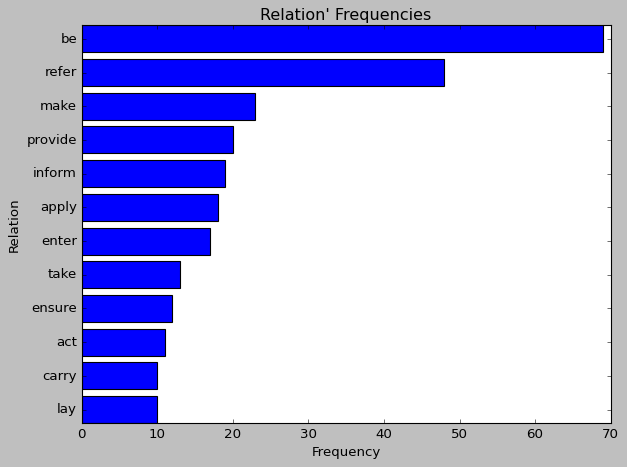

In [65]:
visualization.freq_bar_plot(9)

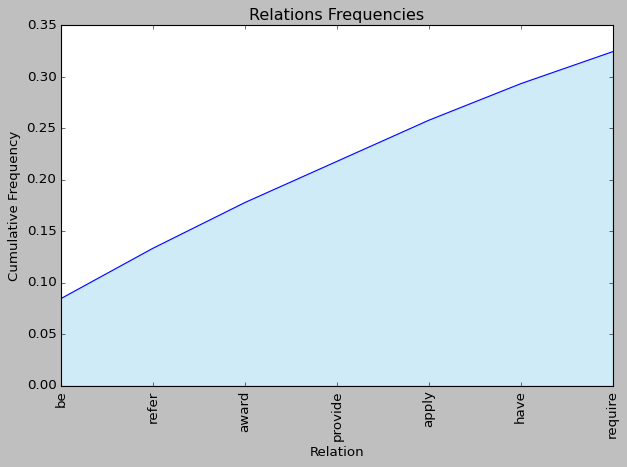

In [ ]:
visualization.cumulative_freq_plot(0)

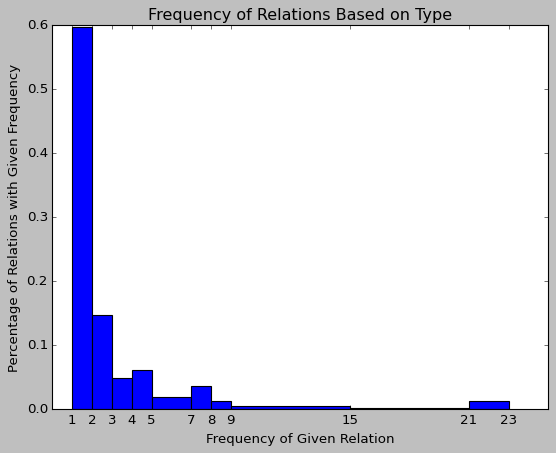

In [37]:
visualization.relations_type_freq_plot()

In [99]:
relation_frequencies = visualization.relations_freq

relation_frequencies[relation_frequencies["Frequency"]>54]

,Relation,Frequency,Relative Freq,Standardized_Frequency,Scaled_Max_Frequency,Cumulative Frequency,Relative Cumulative Frequency
0,replace,69,0.15,8.398383,1.0,69,0.15


In [45]:
def get_filter_dataframe(frequency_border, title):

    visualization = triplets_vis(triplets_neo4j,title)

    relation_frequencies = visualization.relations_freq

    relations_above = relation_frequencies[relation_frequencies["Frequency"]>frequency_border].iloc[:,0].tolist()

    rule_triplets = triplets_neo4j[triplets_neo4j["Title"]==title]

    rule_triplets_filtered = rule_triplets[rule_triplets['Relation'].isin(relations_above)]

    rule_triplets_filtered.reset_index(drop=True, inplace=True)

    return (rule_triplets_filtered)

In [100]:
rule_triplets_XVI = get_filter_dataframe(68, 'TITLE XVI INFORMATION REQUESTS AND DELEGATED ACTS')

In [101]:
rule_triplets_XVI.shape

(69, 9)

In [102]:
rule_triplets_XVI.to_csv(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\triplets_neo4j_whole_tail_small\rule_triplets_XVI.csv', index=False)  

In [ ]:
# triplet I - triplets with freq > 65, captured relat = 0.680412
# triplet II - freq > 2, captured relat = 0.676991
# triplet III - freq > 1, captured relat = 0.483146
# triplet IV - freq > 6, captured relat = 0.475336
# triplet V - freq > 2, captured relat = 0.558719
# triplet VI - freq > 1, captured relat = 0.545455
# triplet VII - freq > 1, captured relat = 0.718750
# triplet VIII - freq > 2, captured relat = 0.755556
# triplet IX - freq > 0, captured relat = 1.00
# triplet X - freq > 1, captured relat = 0.566372
# triplet XI - freq > 1, captured relat = 0.625000
# triplet XII - freq > 0, captured relat = 1.00
# triplet XIII - freq > 1, captured relat = 0.688525
# triplet XIV - freq > 1, captured relat = 0.619048
# triplet XV - freq > 1, captured relat = 0.652174
# triplet XVI - freq > 9, captured relat = 0.426087

In [ ]:
# Smaller Versions 

# triplet II - freq > 9, captured relat = 0.261062
# triplet IV - freq > 48, captured relat = 0.103139
# triplet V - freq > 9, captured relat = 0.263345
# triplet VII - freq > 2, captured relat = 0.484375
# triplet VIII - freq > 7, captured relat = 0.293333
# triplet XVI - freq > 54, captured relat = 0.15

## 2nd Triplets Version: Use each tail noun chunk as tail node 

## For each Title, load the previously created triplets, remove duplicates and rows with head=tail 

In [103]:
def clean_triplets_dataframe(triplet_sub_dataframe):

    triplets_chunks_tails = triplet_sub_dataframe.explode("Tail Noun Chunks", ignore_index=True)

    triplets_chunks_tails = triplets_chunks_tails.rename(columns={'Tail Noun Chunks': 'New Tail'})

    triplets_chunks_tails.drop_duplicates(["Head","Relation",'New Tail','Clean Original Tail'], inplace=True, ignore_index=True)

    triplets_chunks_tails = triplets_chunks_tails[triplets_chunks_tails['Head'] != triplets_chunks_tails['New Tail']]

    return triplets_chunks_tails

def convert_to_list(column):
    return column.apply(ast.literal_eval)

In [104]:
print(os.listdir(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\triplets_neo4j_whole_tail_small'))

['rule_triplets_I.csv', 'rule_triplets_II.csv', 'rule_triplets_III.csv', 'rule_triplets_IV.csv', 'rule_triplets_IX.csv', 'rule_triplets_V.csv', 'rule_triplets_VI.csv', 'rule_triplets_VII.csv', 'rule_triplets_VIII.csv', 'rule_triplets_X.csv', 'rule_triplets_XI.csv', 'rule_triplets_XII.csv', 'rule_triplets_XIII.csv', 'rule_triplets_XIV.csv', 'rule_triplets_XV.csv', 'rule_triplets_XVI.csv']


In [106]:
triplets_folder = r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\triplets_neo4j_whole_tail_small'  
output_expanded_triplets_folder = r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\triplets_neo4j_expanded_tail_chunks_small'

for filename in os.listdir(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\triplets_neo4j_whole_tail_small'):
    file_path = os.path.join(triplets_folder, filename)
    triplets_title = pd.read_csv(file_path)

    triplets_title['Tail Noun Chunks'] = convert_to_list(triplets_title['Tail Noun Chunks'])
    triplets_title['Original Article Text'] = convert_to_list(triplets_title['Original Article Text'])

    expanded_triplets_title = clean_triplets_dataframe(triplets_title)
    
    
    new_filename = filename.split(".")[0] + "_expanded.csv"

    output_file_path = os.path.join(output_expanded_triplets_folder, new_filename)
    expanded_triplets_title.to_csv(output_file_path, index=False)
    

In [193]:
triplets_XVI_exp = pd.read_csv(r'C:\Users\Student\Desktop\Thesis-Coding\Thesis\triplet_neo4j_expanded_tail_chunks\rule_triplets_XVI_expanded.csv')

In [194]:
triplets_XVI_exp.shape

(970, 9)